In [2]:
import tensorflow as tf
tf.enable_eager_execution()

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
tf.__version__

'1.15.3'

In [5]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of Training Examples:", num_train_examples)
print("Number of Testing Examples:", num_test_examples)

Number of Training Examples: 60000
Number of Testing Examples: 10000


In [8]:
# preprocess - normalize the image data from [0,255] to [0,1]
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

# apply normalize function to entire dataset
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# cache images after loading from disk for faster training
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [12]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3921 - acc: 0.8582
Epoch 2/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.2636 - acc: 0.9040
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.2177 - acc: 0.9199
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1812 - acc: 0.9325
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1565 - acc: 0.9423
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1339 - acc: 0.9507
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1128 - acc: 0.9588
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0928 - acc: 0.9655
Epoch 9/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0801 - acc: 0.9706
Epoch 10/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0654 - acc: 0.97

In [13]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.3531 - acc: 0.9109
Accuracy on test dataset: 0.9109


In [14]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [15]:
predictions.shape

(32, 10)

In [16]:
predictions[0]

array([2.8349016e-08, 8.6855416e-14, 1.5397387e-04, 1.3604431e-10,
       9.1626984e-01, 2.3980335e-15, 8.3576150e-02, 2.1352955e-13,
       1.0475120e-10, 6.5913114e-10], dtype=float32)

In [17]:
np.argmax(predictions[0])

4

In [18]:
print(test_labels[0])
print(class_names[4])

4
Coat


In [19]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

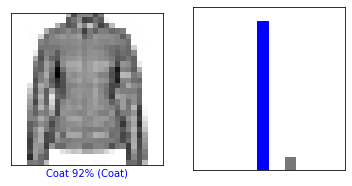

In [20]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

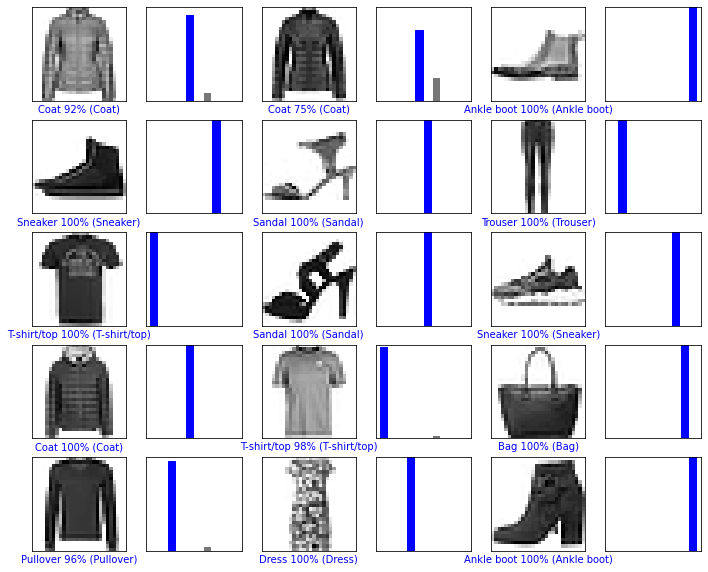

In [21]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [22]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [23]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [24]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.8349122e-08 8.6854752e-14 1.5397373e-04 1.3604483e-10 9.1626984e-01
  2.3980335e-15 8.3576187e-02 2.1352875e-13 1.0475140e-10 6.5912859e-10]]


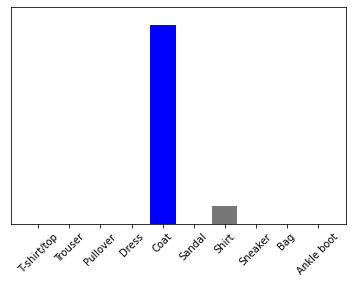

In [25]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [26]:
class_names[np.argmax(predictions_single[0])]

'Coat'